# Ch 4. Generalized Linear Models

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from scipy import stats

%config InlineBackend.figure_format = 'retina'

## Generalized linear models

## Logistic regression

- GLM with a *logistic function* for the inverse link function
    - the output for any input $z$ will lie within the 0 and 1 interval
    - thus, transforms data for a Bernoulli distribution

$$
\text{logistic}(z) = \frac{1}{1 + e^{-z}}
$$

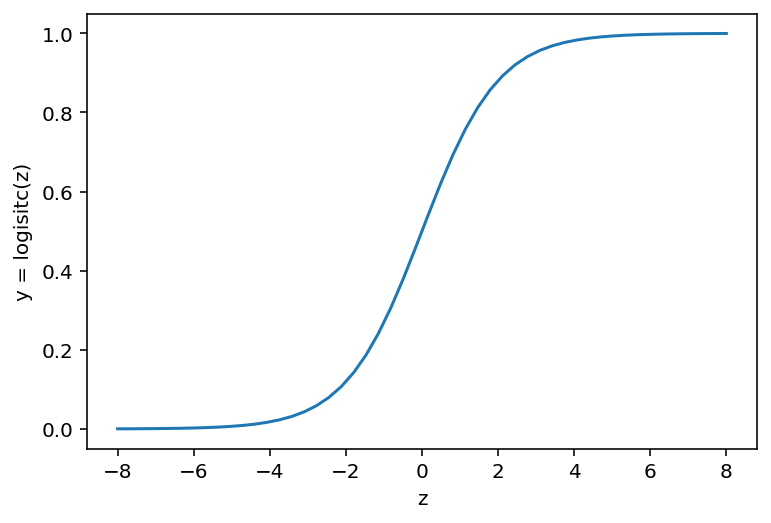

In [2]:
z = np.linspace(-8, 8)
y = 1 / (1 + np.exp(-z))
plt.plot(z, y)
plt.xlabel("z")
plt.ylabel("y = logisitc(z)")
plt.show()

### The logistic model

- same as a linear regression, just using the logistic link function and the Bernoulli likelihood function

$$
\theta = logistic(\alpha + x \beta) \\
y \sim \text{Bernoulli}(\theta)
$$

### The Iris dataset

In [3]:
iris = pd.read_csv("data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


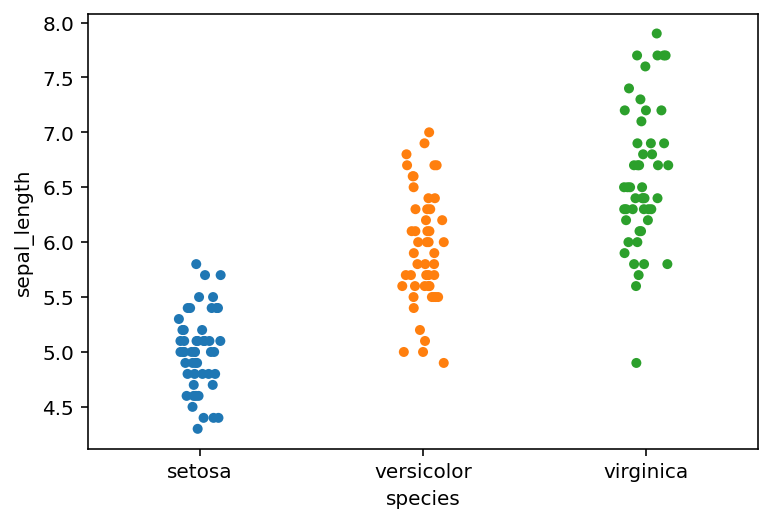

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.show()

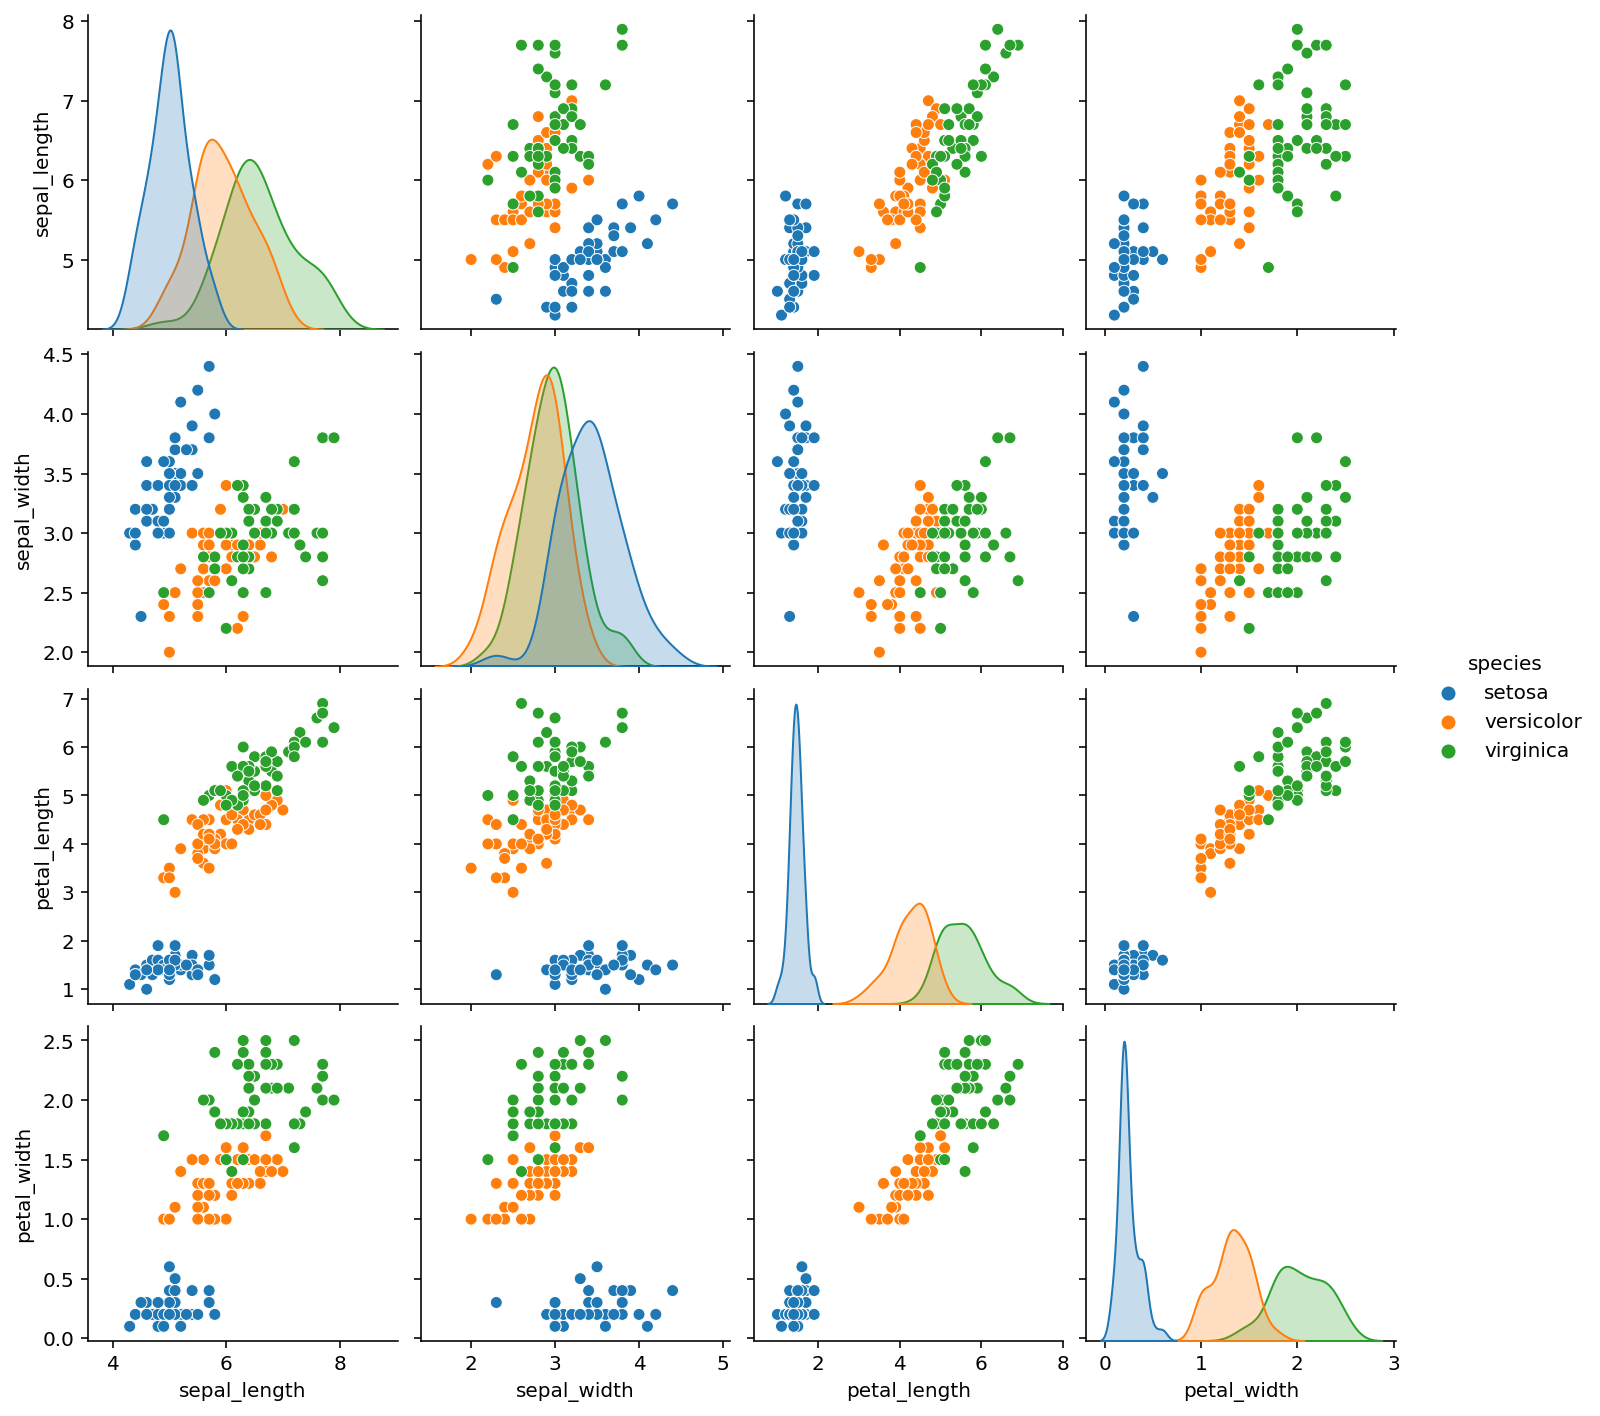

In [5]:
sns.pairplot(iris, hue="species", diag_kind="kde")
plt.show()

#### The logistic model applied to the Iris dataset

- classify `setosa` vs. `versicolor` using `sepal_length` as the only predictor
    - encode the species as 0 and 1, respectively

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()  # center the data

- two deterministic variables in this model:
    - `θ`: ouput of the logistic function applied to `µ`
    - `bd`: the "boundary decision" is the value of the predictor variable used to separate classes

In [7]:
with pm.Model() as model_0:
    α = pm.Normal("α", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=10)

    µ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(µ))
    bd = pm.Deterministic("bd", -α / β)

    y1 = pm.Bernoulli("y1", p=θ, observed=y_0)

    trace_0 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


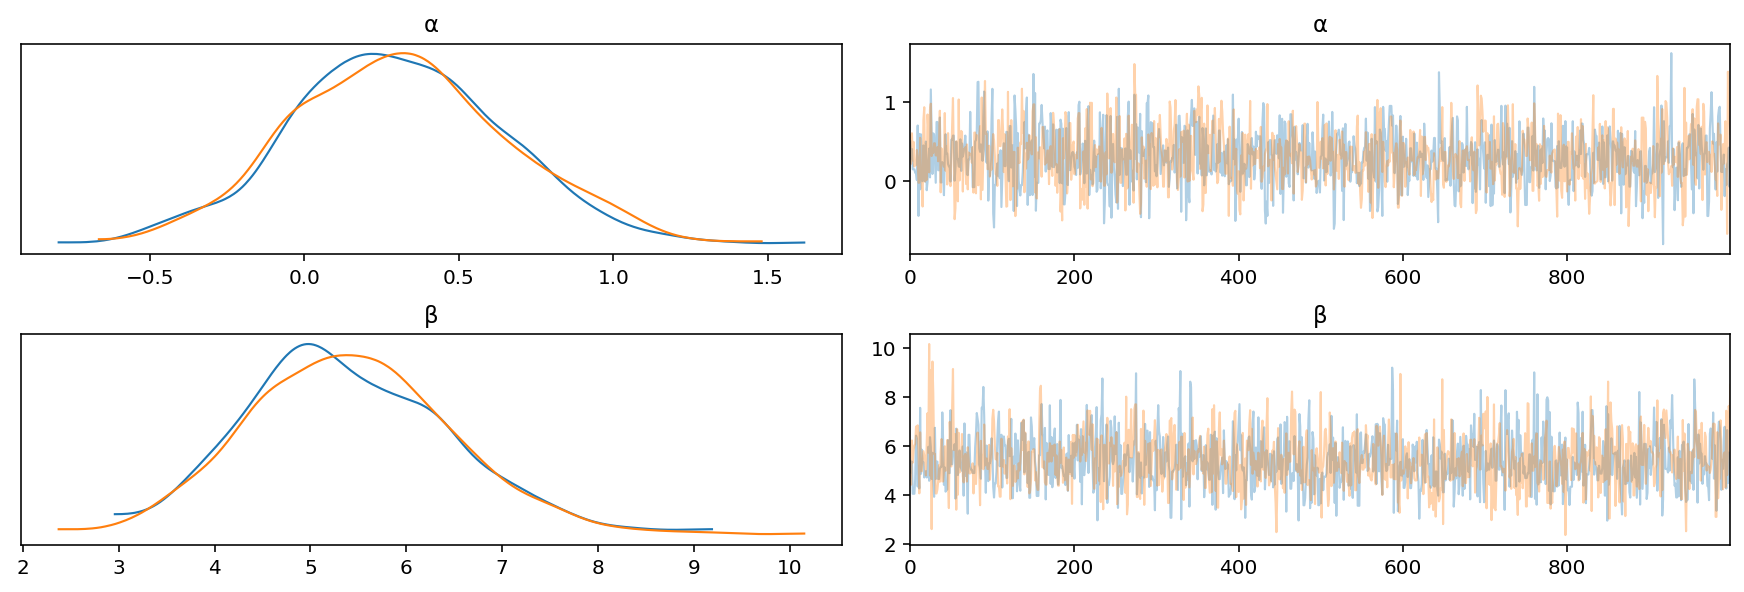

In [8]:
az_trace_0 = az.from_pymc3(trace_0, model=model_0)
az.plot_trace(az_trace_0, var_names=["α", "β"])
plt.show()

In [9]:
az.summary(az_trace_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.304,0.346,-0.318,0.994,0.009,0.007,1592.0,1204.0,1602.0,1500.0,1.0
β,5.409,1.078,3.553,7.502,0.027,0.020,1538.0,1446.0,1577.0,1232.0,1.0
θ[0],0.163,0.058,0.060,0.266,0.001,0.001,2022.0,1966.0,1981.0,1446.0,1.0
θ[1],0.067,0.036,0.011,0.131,0.001,0.001,1940.0,1878.0,1883.0,1267.0,1.0
θ[2],0.027,0.021,0.002,0.062,0.000,0.000,1864.0,1864.0,1809.0,1331.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
θ[96],0.814,0.069,0.684,0.932,0.002,0.001,1508.0,1486.0,1465.0,1333.0,1.0
θ[97],0.979,0.019,0.944,1.000,0.000,0.000,1552.0,1551.0,1472.0,1185.0,1.0
θ[98],0.163,0.058,0.060,0.266,0.001,0.001,2022.0,1966.0,1981.0,1446.0,1.0
θ[99],0.814,0.069,0.684,0.932,0.002,0.001,1508.0,1486.0,1465.0,1333.0,1.0


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


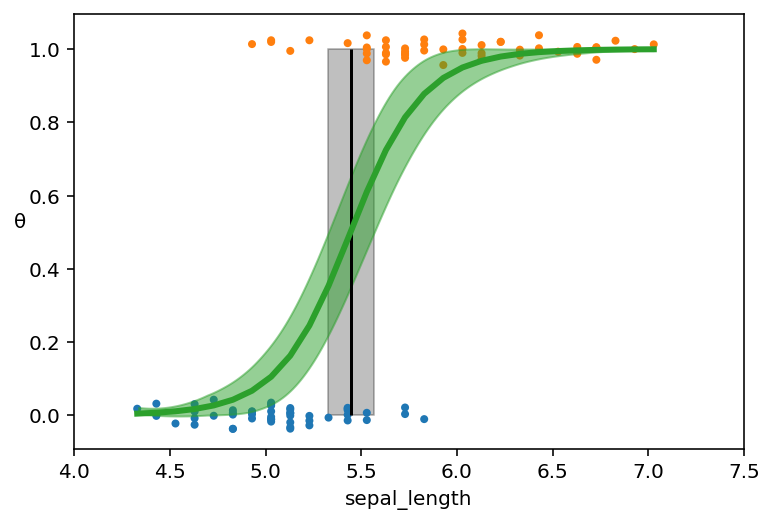

In [10]:
theta = trace_0["θ"].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color="C2", lw=3)
plt.vlines(trace_0["bd"].mean(), 0, 1, color="k")
bd_hpi = az.hdi(trace_0["bd"])
plt.fill_between(bd_hpi, 0, 1, color="k", alpha=0.25)
plt.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, trace_0["θ"], color="C2", ax=plt.gca())

plt.xlabel(x_n)
plt.ylabel("θ", rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

plt.show()

## Multiple logistic regression

In [11]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df.species).codes
x_n = ["sepal_length", "sepal_width"]
x_1 = df[x_n].values

### The boundary decision

$$
0.5 = \text{logistic}(\alpha + \beta_1 x_1 + \beta_2 x_2) \Leftrightarrow 0 = \alpha + \beta_1 x_1 + \beta_2 x_2 \\
x_2 = - \frac{\alpha}{\beta_2} - \frac{\beta_1}{\beta_2}x_1
$$

### Implementing the model

In [12]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=2, shape=len(x_n))

    mu = alpha + pm.math.dot(x_1, beta)
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic(
        "bd", -1.0 * alpha / beta[1] - (x_1[:, 0] * beta[0] / beta[1])
    )

    y1 = pm.Bernoulli("y1", p=theta, observed=y_1)

    trace_1 = pm.sample(2000)

az_trace_1 = az.from_pymc3(trace=trace_1, model=model_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 40 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


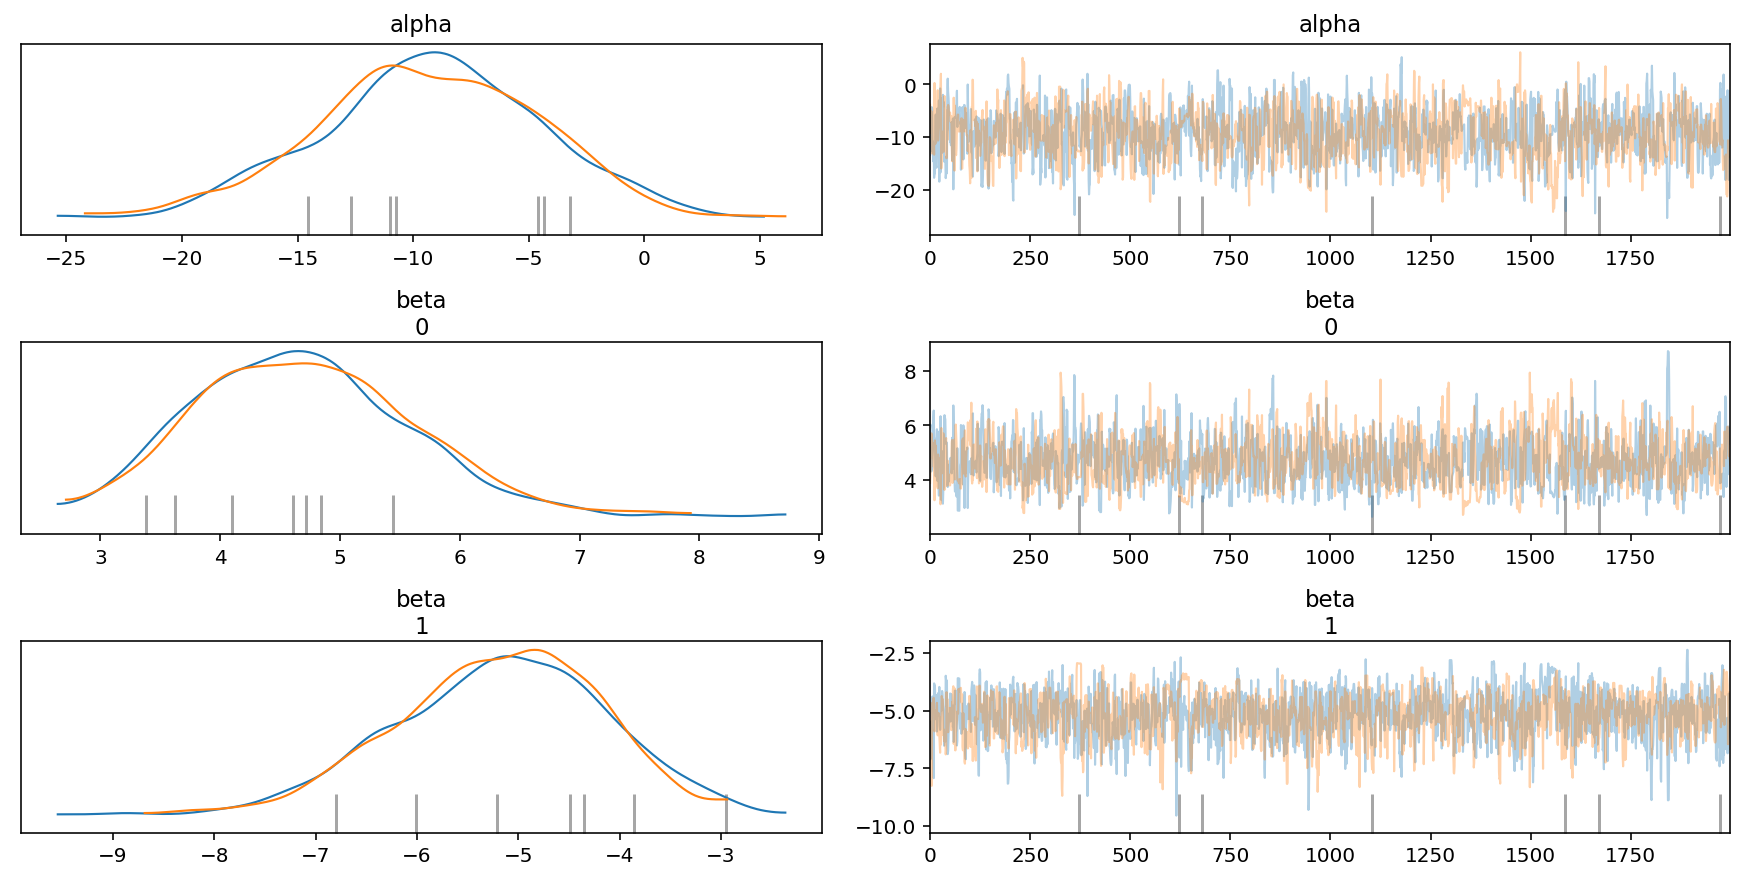

In [13]:
az.plot_trace(az_trace_1, var_names=["alpha", "beta"])
plt.show()

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


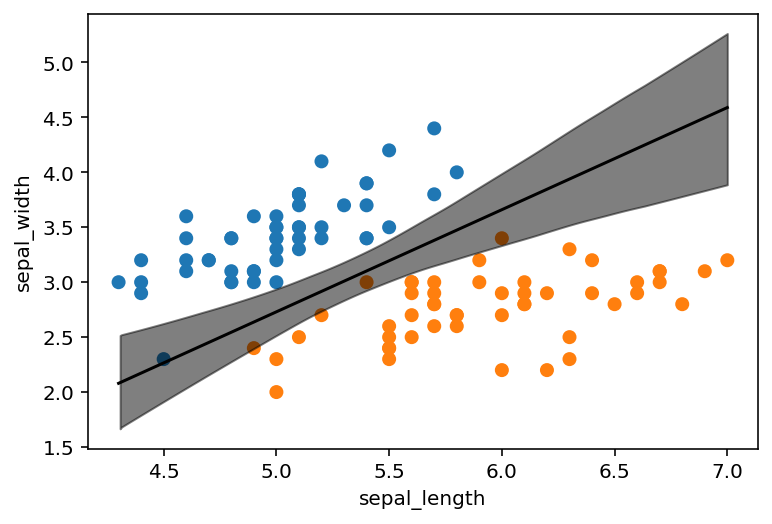

In [14]:
idx = np.argsort(x_1[:, 0])
bd = trace_1["bd"].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c=[f"C{x}" for x in y_0])
plt.plot(x_1[:, 0][idx], bd, color="k")
az.plot_hdi(x_1[:, 0], trace_1["bd"], color="k", ax=plt.gca())
plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()

### Interpreting the coefficients of a logisitic regression

- because the model uses a non-linear link function, the effect of $\beta$ is a non-linear function on $x$
    - if $\beta$ is positive, then as $x$ increases, so to does $\Pr(y=1)$, but non-linearly
- some algebra to understand the effect of a coefficient

$$
\theta = \text{logistic}(\alpha + X \beta) \quad \text{logit}(z) = \log(\frac{z}{1-z}) \\
\text{logit}(\theta) = \alpha + X \beta \\
\log(\frac{\theta}{1-\theta}) = \alpha + X \beta \\
\log(\frac{\Pr(y=1)}{1-\Pr(y=1)}) = \alpha + X \beta
$$

- recall: $\frac{\Pr(y=1)}{1 - \Pr(y=1)}$ = **"odds"**
    - *"In a logistic regression, the $\beta$ coefficient encodes the increase in log-odds units by unit increase of the $x$ variable."*

### Dealing with correlated variables

- author recommends scale and standardize all non-categorical variables then use a Student's t-distribution for the prior

### Dealing with unbalanced classes

- logistic regression had difficulty finding the boundary when the classes are unbalanced
- for an example, we will use the Iris data set 

In [15]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df.species).codes
x_n = ["sepal_length", "sepal_width"]
x_3 = df[x_n].values

In [16]:
with pm.Model() as model_3:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=2, shape=len(x_n))

    mu = alpha + pm.math.dot(x_3, beta)
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic(
        "bd", -1.0 * alpha / beta[1] - (x_3[:, 0] * beta[0] / beta[1])
    )

    y1 = pm.Bernoulli("y1", p=theta, observed=y_3)

    trace_3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
az_trace_3 = az.from_pymc3(trace=trace_3, model=model_3)

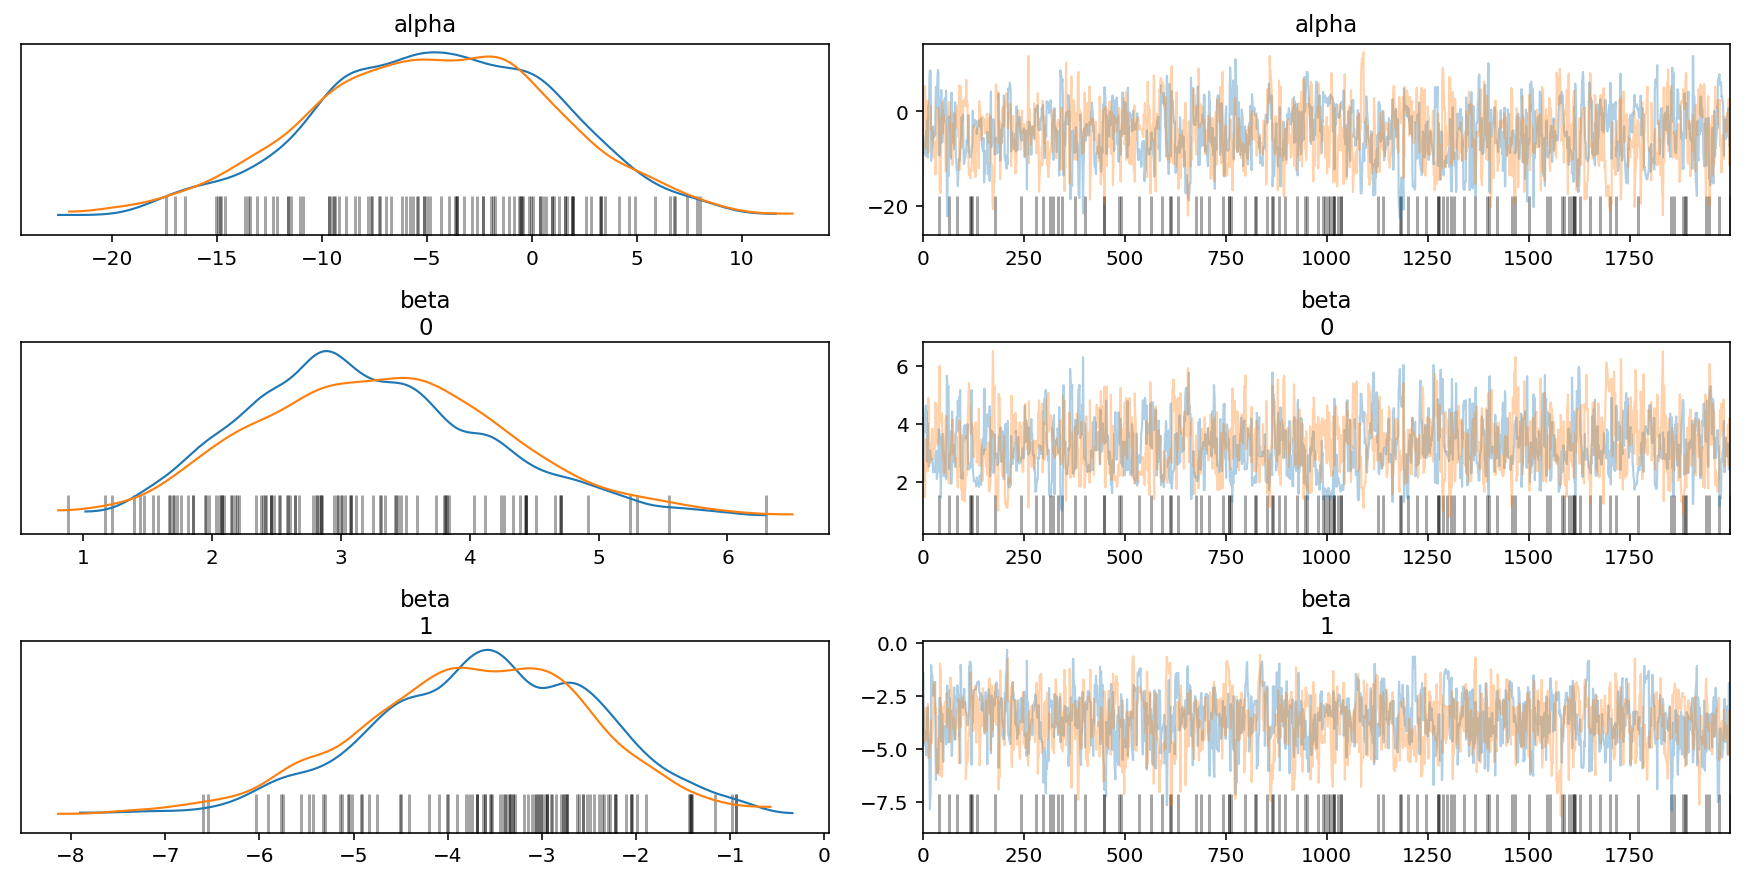

In [18]:
az.plot_trace(az_trace_3, var_names=["alpha", "beta"])
plt.show()

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


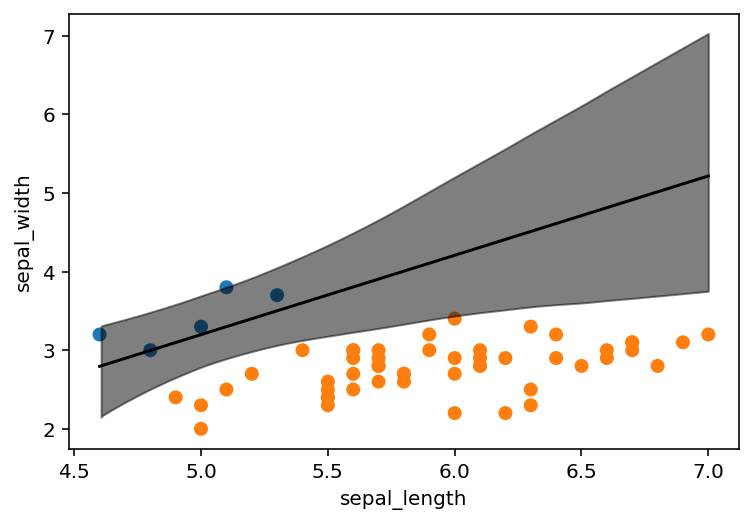

In [19]:
idx = np.argsort(x_3[:, 0])
bd = trace_3["bd"].mean(0)[idx]
plt.scatter(x_3[:, 0], x_3[:, 1], c=[f"C{x}" for x in y_3])
plt.plot(x_3[:, 0][idx], bd, color="k")
az.plot_hdi(x_3[:, 0], trace_3["bd"], color="k", ax=plt.gca())
plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()

- options to fix the problem of unbalanced data:
    - collect equal amounts of all classes (not always possible)
    - add prior information to help constrain the model
    - check the uncertainty of the model and run PPCs to see if the results are useful
    - create alternative models (explained later in this chapter)

### Softmax regression

- *softmax regression* is one way to generalize logistic regression to more than two classes

### Discrimitive and generative models

- a discriminating model can also be made by finding the means of both data sets and taking the average

## Poisson regression

- useful for count data
    - discrete, non-negative integers

### Poisson distribution

- the number of expected events within a given amount of time
- assumes events occur independently of each other and at a fixed rate
- parameterized using one value $\mu$ (often $\lambda$ is used, too)
    - probability mass function of Poisson distribution:
        - $\mu$: average number of events per unit time/space
        - $x$: a positive integer value

$$
f(x|\mu) = \frac{e^{-\mu} \mu^x}{x!}
$$

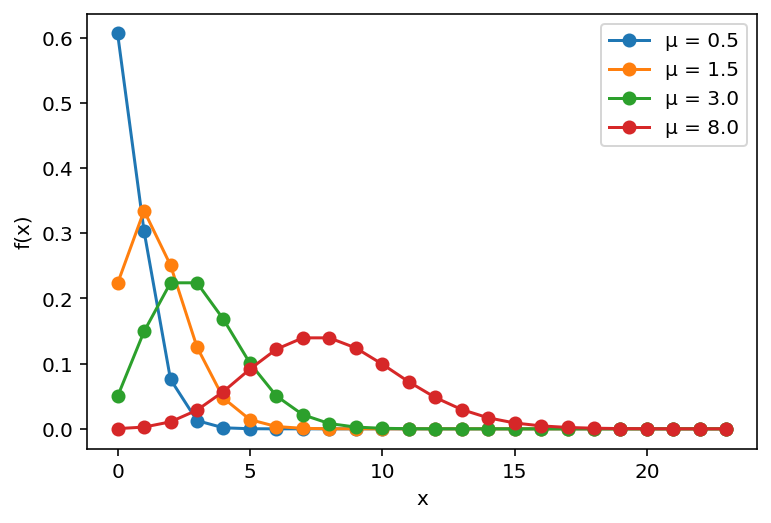

In [20]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, "o-", label=f"µ = {mu:3.1f}")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

- Poisson distribution is a special case of binomial distribution when the number of trials $n$ is very large and the probability of success $p$ is very low

### The zero-inflated Poisson model

- use if extra 0's due to missing data - not real 0's
- mixture of 2 processes:
    - one modeled by a Poisson with probability $\psi$
    - one giving extra zeros with probability $1 - \psi$

$$
\Pr(y_j = 0) = 1 - \psi + \psi e^{-\mu} \qquad \Pr(y_j = k_i) = \psi \frac{\mu^{x_i} e ^{-\mu}}{x_i !}
$$

- example with mock data

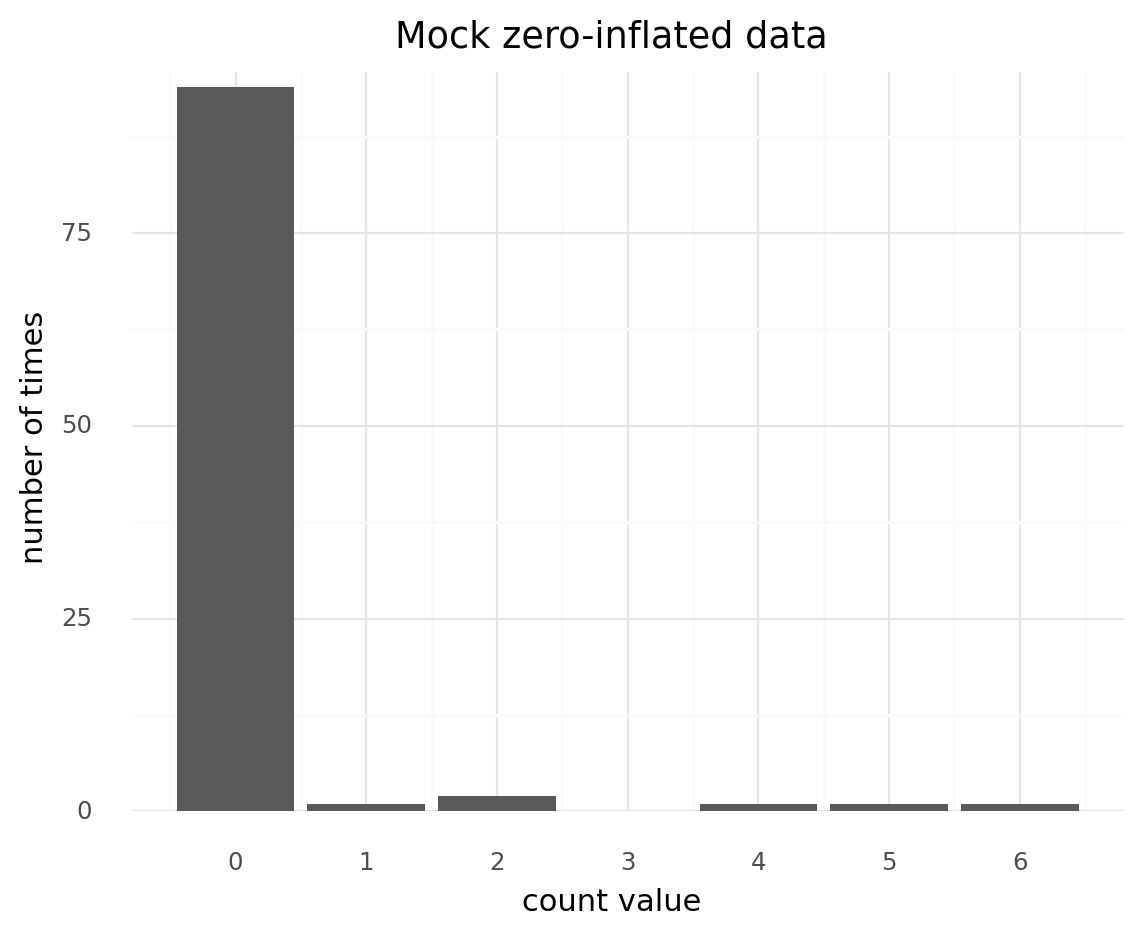

<ggplot: (8762941868581)>

In [21]:
n = 100
theta_real = 2.5
psi_real = 0.1

counts = np.array(
    [
        (np.random.random() > (1 - psi_real)) * np.random.poisson(theta_real)
        for i in range(n)
    ]
)

counts_df = pd.DataFrame({"x": counts})
(
    gg.ggplot(counts_df)
    + gg.aes(x="x")
    + gg.geom_bar()
    + gg.scale_x_continuous(breaks=range(0, 7))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme_minimal()
    + gg.labs(x="count value", y="number of times", title="Mock zero-inflated data")
)

- fit model with built-in zero-inflated Poisson function

In [22]:
with pm.Model() as ZIP:
    psi = pm.Beta("psi", 1, 1)
    theta = pm.Gamma("theta", 2, 0.1)
    y = pm.ZeroInflatedPoisson("y", psi, theta, observed=counts)
    trace_zip = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, psi]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.


In [23]:
az_trace_zip = az.from_pymc3(trace=trace_zip, model=ZIP)

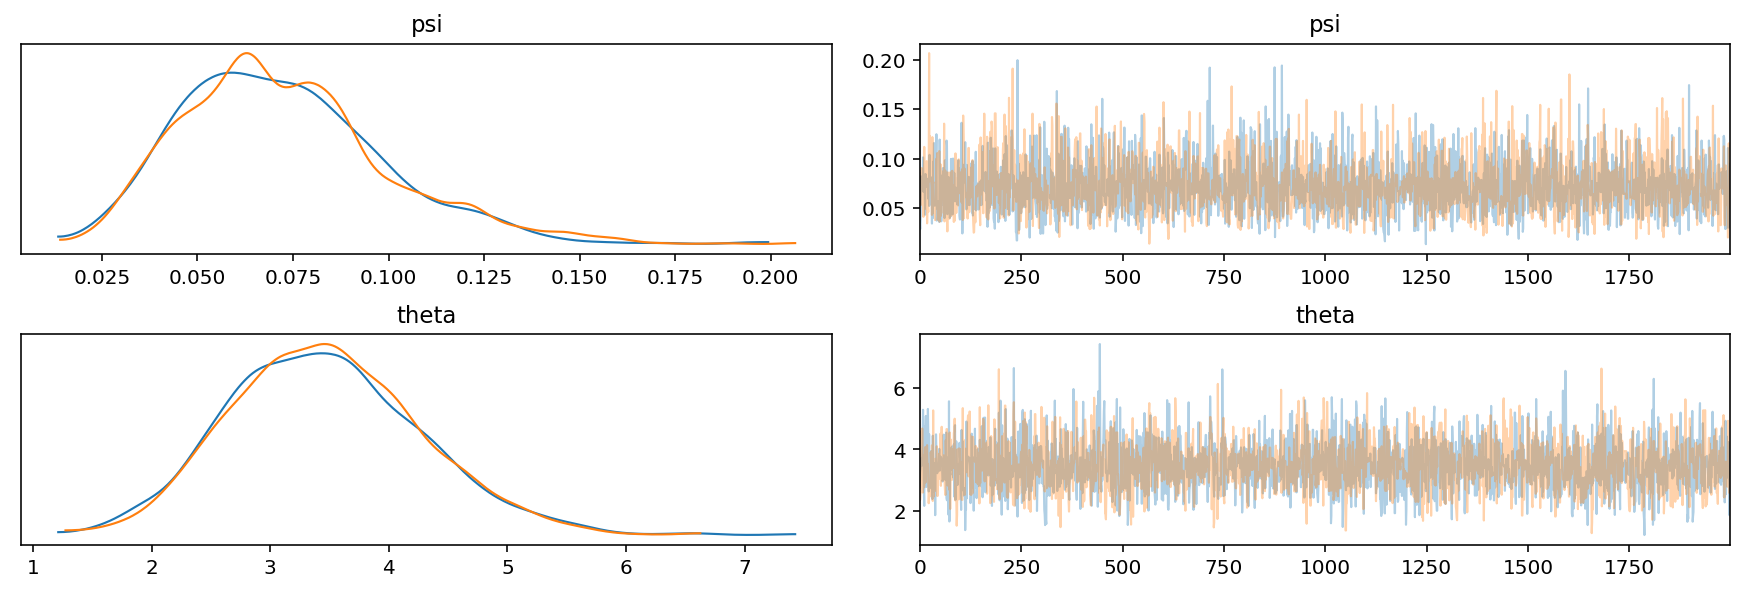

In [24]:
az.plot_trace(az_trace_zip)
plt.show()

In [25]:
az.summary(az_trace_zip)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
psi,0.072,0.027,0.029,0.125,0.000,0.00,3425.0,3425.0,3171.0,2564.0,1.0
theta,3.462,0.805,2.021,5.033,0.014,0.01,3208.0,3208.0,3141.0,2308.0,1.0


### Poisson regression and ZIP regression

- can use the Poisson or ZIP in a linear regression
    - use the exponential function as the inverse link function

$$
\theta = e^{\alpha + X \beta}
$$

- example with fishing data at a park
    - data: `count`: number of fish caught, `child`: number of children in group, `camper`: if they brought a camper
    - model: the number of fish caught

In [26]:
fish_data = pd.read_csv("data/fish.csv")
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [27]:
fish_data.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


In [28]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta("psi", 1, 1)
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=2)

    theta = pm.math.exp(
        alpha + beta[0] * fish_data["child"] + beta[1] * fish_data["camper"]
    )
    y1 = pm.ZeroInflatedPoisson("y1", psi, theta, observed=fish_data["count"])

    trace_ZIP_reg = pm.sample(2000)
    ZIP_reg_ppc = pm.sample_posterior_predictive(trace_ZIP_reg)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8982315566653549, but should be close to 0.8. Try to increase the number of tuning steps.


In [29]:
az_trace_ZIP_reg = az.from_pymc3(
    trace_ZIP_reg, model=ZIP_reg, posterior_predictive=ZIP_reg_ppc
)

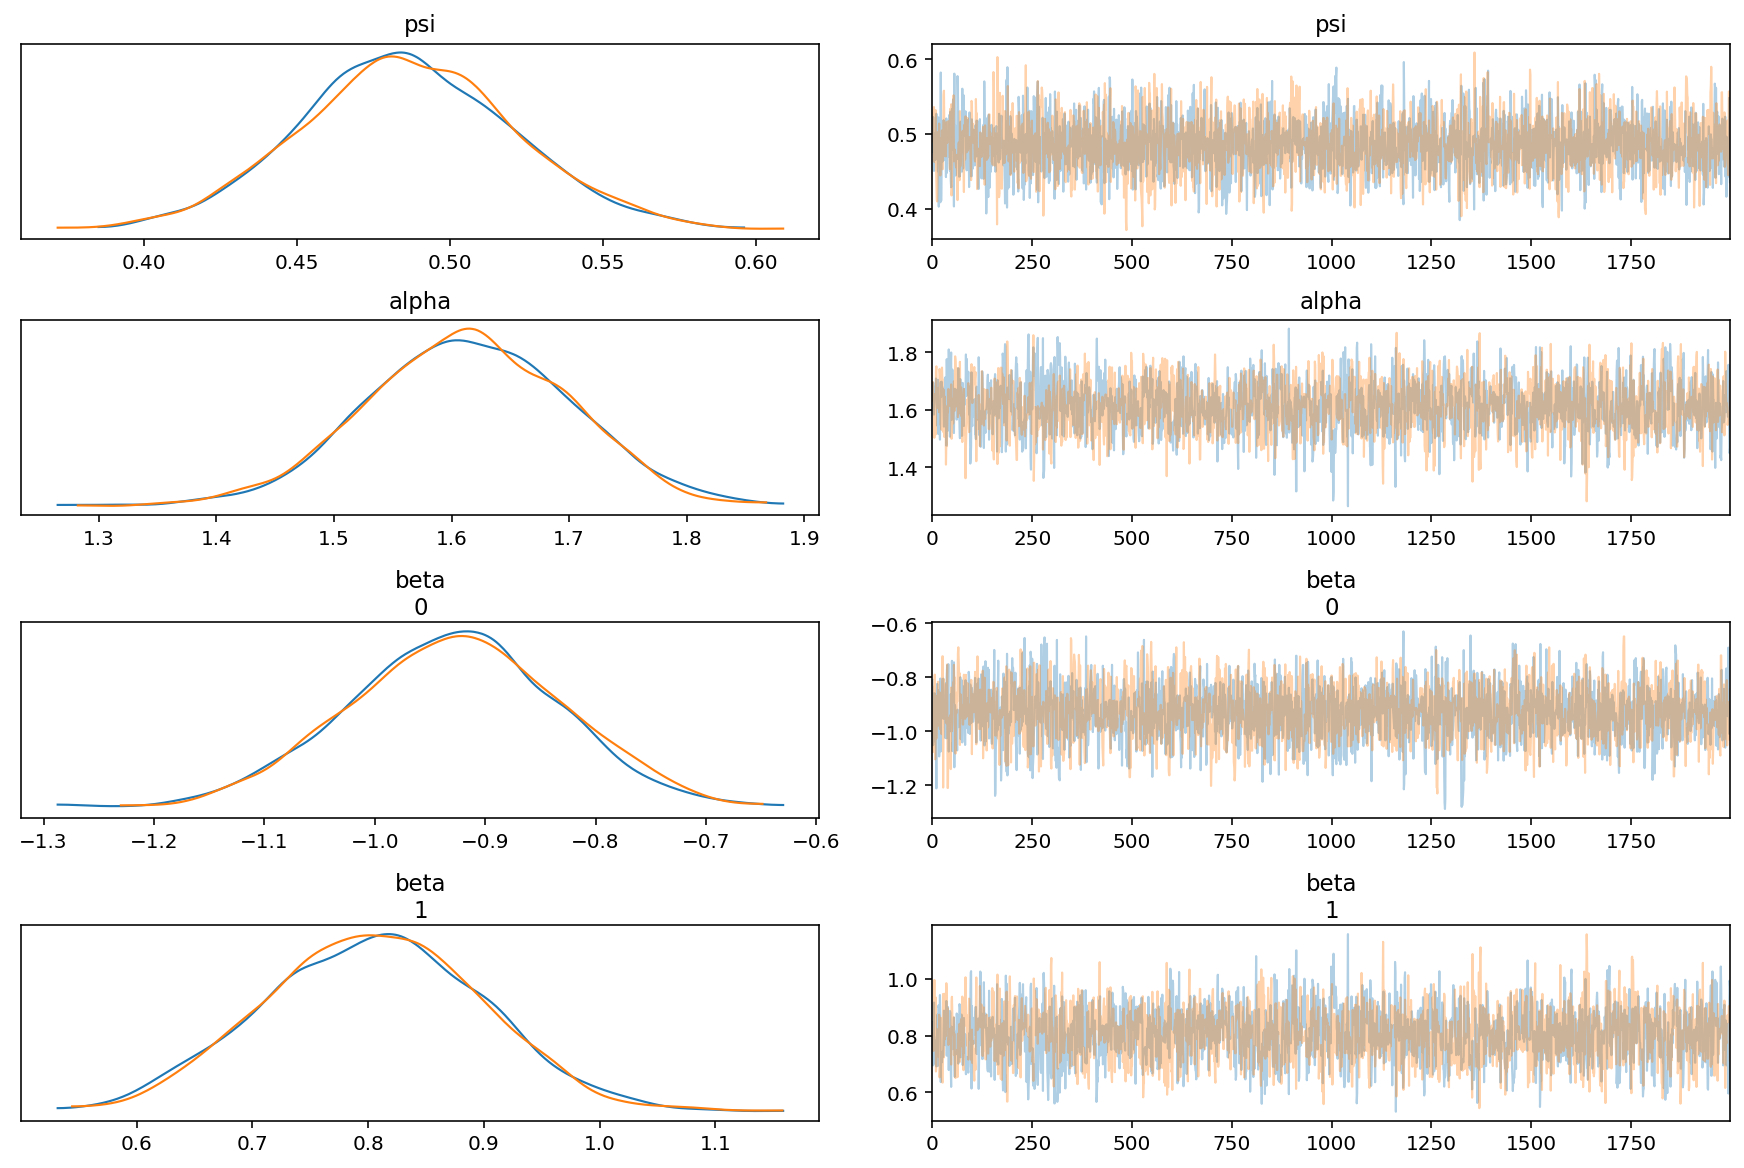

In [30]:
az.plot_trace(az_trace_ZIP_reg, var_names=["psi", "alpha", "beta"])
plt.show()

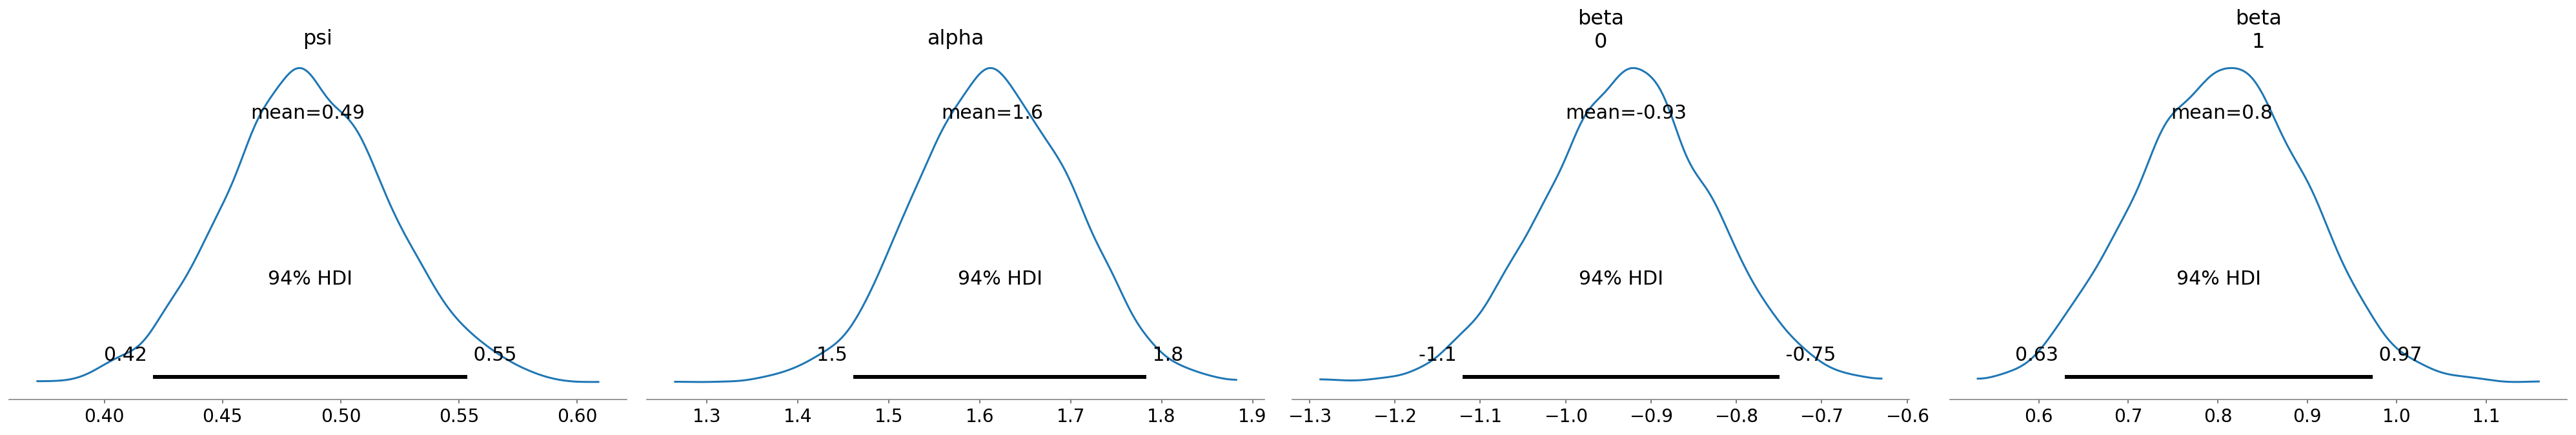

In [31]:
az.plot_posterior(az_trace_ZIP_reg, var_names=["psi", "alpha", "beta"])
plt.show()

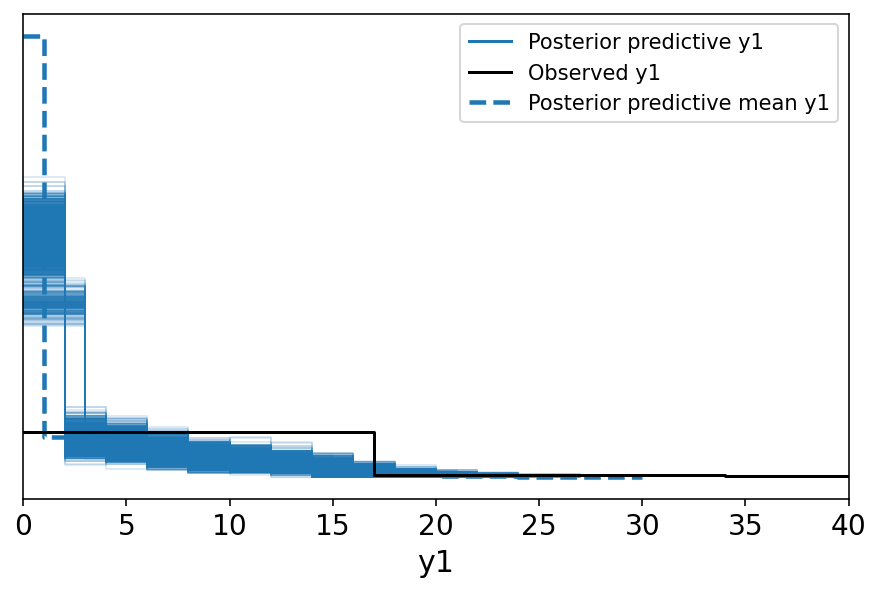

In [32]:
az.plot_ppc(az_trace_ZIP_reg)
plt.xlim((0, 40))
plt.show()

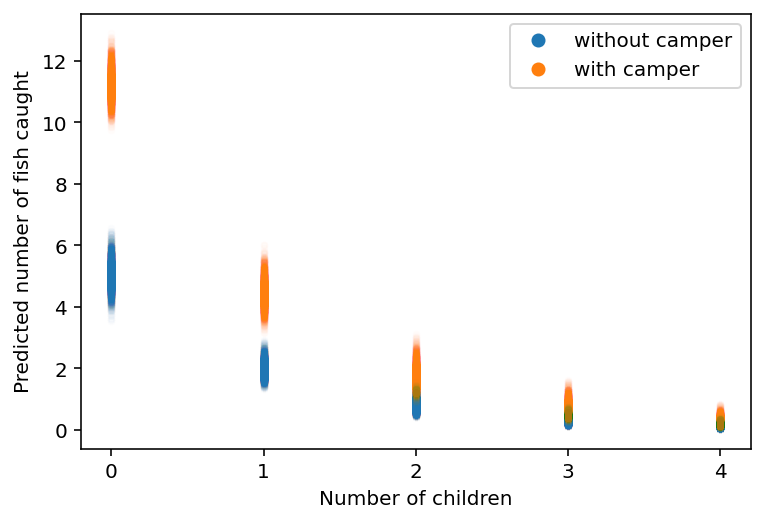

In [33]:
children = list(range(5))
fish_count_pred0 = []
fish_count_pred1 = []

for n in children:
    without_camper = trace_ZIP_reg["alpha"] + trace_ZIP_reg["beta"][:, 0] * n
    with_camper = without_camper + trace_ZIP_reg["beta"][:, 1]
    fish_count_pred0.append(np.exp(without_camper))
    fish_count_pred1.append(np.exp(with_camper))

plt.plot(children, fish_count_pred0, "C0.", alpha=0.01)
plt.plot(children, fish_count_pred1, "C1.", alpha=0.01)


plt.xticks(children)
plt.xlabel("Number of children")
plt.ylabel("Predicted number of fish caught")
plt.plot([], "C0o", label="without camper")
plt.plot([], "C1o", label="with camper")
plt.legend(loc="upper right")
plt.show()

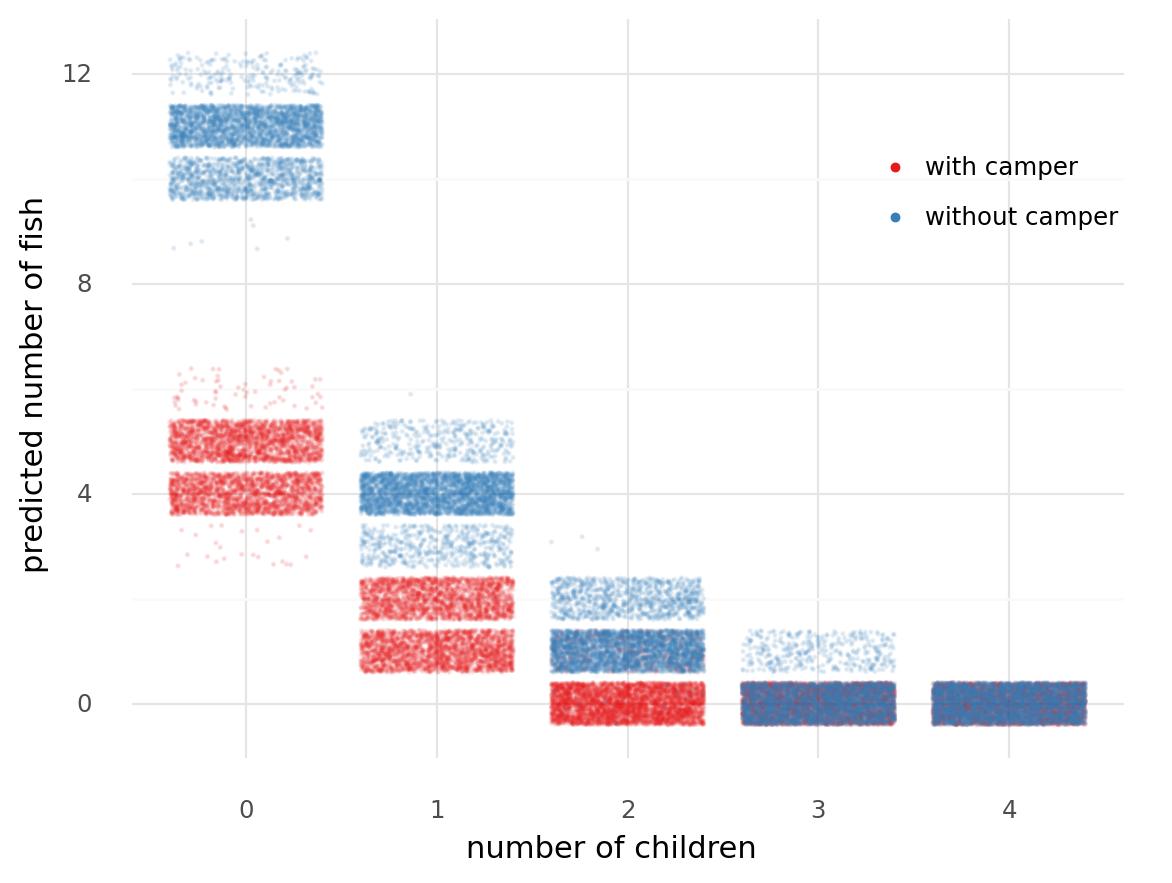

<ggplot: (8762919614278)>

In [34]:
df1 = pd.DataFrame(
    {
        "children": children,
        "camper": ["with camper" for i in range(len(children))],
        "fish_count": fish_count_pred0,
    }
).explode("fish_count")

df2 = pd.DataFrame(
    {
        "children": children,
        "camper": ["without camper" for i in range(len(children))],
        "fish_count": fish_count_pred1,
    }
).explode("fish_count")

fish_pred_df = pd.concat([df1, df2]).astype({"fish_count": "int64"})

(
    gg.ggplot(
        fish_pred_df, gg.aes(x="factor(children)", y="fish_count", color="camper")
    )
    + gg.geom_jitter(size=0.1, alpha=0.1)
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        guide=gg.guide_legend(override_aes={"size": 1, "alpha": 1}),
    )
    + gg.theme_minimal()
    + gg.theme(legend_position=(0.8, 0.7), legend_title=gg.element_blank())
    + gg.labs(x="number of children", y="predicted number of fish")
)

## Robust logistic regression

## The GLM module

- a minimal interface for basic and simple models
    - uses the *formula mini-language* from R (uses ['Patsy'](https://patsy.readthedocs.io/en/latest/index.html) under-the-hood)

---

In [35]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-04

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

pymc3     : 3.9.3
scipy     : 1.6.0
seaborn   : 0.11.1
matplotlib: 3.3.3
numpy     : 1.19.4
plotnine  : 0.7.1
pandas    : 1.2.0
arviz     : 0.10.0

